In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'viridis'
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
from skimage.io import imread
from skimage.util import montage
from tqdm import tqdm
tqdm.pandas() # hack progressbars into pandas
montage_rgb = lambda x, **kwargs: np.stack([montage(x[:, :, :, i], **kwargs) for i in range(x.shape[3])], -1)

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"cassidygasteiger","key":"6c9923a920bf29bf27fe448f3041bf1e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d cassidygasteiger/new-hurricane-damage-sat-images

 99% 208M/210M [00:12<00:00, 23.4MB/s]
100% 210M/210M [00:13<00:00, 16.9MB/s]


In [ ]:
!unzip new-hurricane-damage-sat-images.zip -d /content/new-hurricane-damage-sat-images-unzippedA

Streaming output truncated to the last 5000 lines.
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4593.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4594.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4595.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4596.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4597.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4598.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4599.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/46.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/460.jpeg  
  inflating: /content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/imagery/4600.jpeg  
  inflating: /content/

In [ ]:
#make a df of the image paths
satellite_dir = Path('../content/new-hurricane-damage-sat-images-unzippedA/')
image_df = pd.DataFrame({'path': list(satellite_dir.glob('**/*.jp*g'))})
image_df.head(5)

,path
0,../content/new-hurricane-damage-sat-images-unz...
1,../content/new-hurricane-damage-sat-images-unz...
2,../content/new-hurricane-damage-sat-images-unz...
3,../content/new-hurricane-damage-sat-images-unz...
4,../content/new-hurricane-damage-sat-images-unz...


In [ ]:
#combine image path df with labels
labels = pd.read_csv('../content/new-hurricane-damage-sat-images-unzippedA/PRJ-2974/distance_elevation.csv')
#labels.head(5)
labels['img_id'] = labels['img_id'].astype(str)
image_df['img_id'] = image_df['path'].apply(lambda x: str(x.stem))
merged_df = pd.merge(image_df, labels, on = 'img_id')
merged_df.drop(columns = ['img_id'], inplace=True)
merged_df = merged_df.drop(columns = ['Unnamed: 0'])
merged_df.head(5)

,path,distance,complete_post_catalog_id,label,coord_x,coord_y,elevation
0,../content/new-hurricane-damage-sat-images-unz...,21171.075020,105001000B95E200,Undamaged,-95.370587,29.768079,13.291325
1,../content/new-hurricane-damage-sat-images-unz...,170243.223900,1.04E+12,Damaged,-96.939641,28.764159,24.749996
2,../content/new-hurricane-damage-sat-images-unz...,8949.754394,105001000B95E100,Damaged,-95.513427,29.744835,18.762648
3,../content/new-hurricane-damage-sat-images-unz...,50602.155240,105001000B95E200,Damaged,-95.066049,29.831623,2.302779
4,../content/new-hurricane-damage-sat-images-unz...,172074.909300,1.04E+12,Damaged,-96.976177,28.775391,23.128298


In [ ]:
X = merged_df['path']
y = merged_df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(X_train)

19343    ../content/new-hurricane-damage-sat-images-unz...
10352    ../content/new-hurricane-damage-sat-images-unz...
14443    ../content/new-hurricane-damage-sat-images-unz...
15267    ../content/new-hurricane-damage-sat-images-unz...
1593     ../content/new-hurricane-damage-sat-images-unz...
                               ...                        
24197    ../content/new-hurricane-damage-sat-images-unz...
2163     ../content/new-hurricane-damage-sat-images-unz...
22676    ../content/new-hurricane-damage-sat-images-unz...
21069    ../content/new-hurricane-damage-sat-images-unz...
6211     ../content/new-hurricane-damage-sat-images-unz...
Name: path, Length: 14625, dtype: object


In [ ]:
train = pd.DataFrame(zip(X_train, y_train), columns = ['path', 'label'])
test = pd.DataFrame(zip(X_test, y_test), columns = ['path', 'label'])
val = pd.DataFrame(zip(X_val, y_val), columns = ['path', 'label'])

In [ ]:
train_damage = train[train['label'] == 'Damaged']
train_nondamage = train[train['label'] == 'Undamaged']
test_damage = test[test['label'] == 'Damaged']
test_nondamage = test[test['label'] == 'Undamaged']
val_damage = val[val['label'] == 'Damaged']
val_nondamage = val[val['label'] == 'Undamaged']

In [ ]:
import os

os.makedirs("/content/train/damage/", exist_ok=True)

for i in train_damage.index:
  shutil.move(train_damage['path'][i], "/content/train/damage/")

In [ ]:
os.makedirs("/content/test/damage/", exist_ok=True)

for i in test_damage.index:
  shutil.move(test_damage['path'][i], "test/damage/")

In [ ]:
os.makedirs("/content/validation/damage/", exist_ok=True)

for i in val_damage.index:
  shutil.move(val_damage['path'][i], "validation/damage/")

In [ ]:
os.makedirs("/content/train/no_damage/", exist_ok=True)

for i in train_nondamage.index:
  shutil.move(train_nondamage['path'][i], "train/no_damage/")

In [ ]:
os.makedirs("/content/test/no_damage/", exist_ok=True)

for i in test_nondamage.index:
  shutil.move(test_nondamage['path'][i], "test/no_damage/")

In [ ]:
os.makedirs("/content/validation/no_damage/", exist_ok=True)

for i in val_nondamage.index:
  shutil.move(val_nondamage['path'][i], "validation/no_damage/")

In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    device = torch.device("cuda")
else:
    print("GPU is not available. Using CPU.")
    device = torch.device("cpu")

GPU is available!


In [ ]:
# with open("www.designsafe-ci.org/data/browser/public/designsafe.storage.published/PRJ-2974/imagery", "r") as file:
#     data = file.read()
#     print(data)

In [ ]:
original_dataset_dir = '/content'

In [ ]:
train_damage_dir = original_dataset_dir + '/train/damage'
validation_damage_dir = original_dataset_dir + '/validation/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [ ]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  8432
total validation damage images:  2763
total test damage images:  2798
total training no damage images:  6193
total validation no damage images:  2113
total test no damage images:  2078


In [ ]:
import torch
from torch import nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MyModel()

In [ ]:
# i = 0
# for inputs, labels in train_loader:
#   print(inputs)
#   print(labels)
#   i += 1
#   if i > 1:
#     break

In [ ]:
print(os.path.join('/content/train'))
print(type(os.path.join('/content/train')))

/content/train
<class 'str'>


In [ ]:
# Create the model
model = MyModel()

# Set the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Data preprocessing and normalization
data_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the datasets
train_dataset = datasets.ImageFolder(os.path.join('/content/train'), transform=data_transforms)
validation_dataset = datasets.ImageFolder(os.path.join('/content/validation'), transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
print(train_loader)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.size())
        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)

    model.eval()
    validation_loss = 0.0
    validation_acc = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            validation_loss += loss.item()
            validation_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    validation_loss /= len(validation_loader)
    validation_acc /= len(validation_dataset)

    train_acc_values.append(train_acc)
    val_acc_values.append(validation_acc)
    train_loss_values.append(train_loss)
    val_loss_values.append(validation_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}')
    print(f'Validation Loss: {validation_loss:.4f}  Validation Acc: {validation_acc:.4f}')

Epoch 1/10
Train Loss: 0.3607  Train Acc: 0.8373
Validation Loss: 0.2763  Validation Acc: 0.8876
Epoch 2/10
Train Loss: 0.2693  Train Acc: 0.8900
Validation Loss: 0.2644  Validation Acc: 0.8913
Epoch 3/10
Train Loss: 0.2380  Train Acc: 0.9023
Validation Loss: 0.2286  Validation Acc: 0.9022
Epoch 4/10
Train Loss: 0.2116  Train Acc: 0.9164
Validation Loss: 0.1965  Validation Acc: 0.9190
Epoch 5/10
Train Loss: 0.1922  Train Acc: 0.9253
Validation Loss: 0.4595  Validation Acc: 0.7248
Epoch 6/10
Train Loss: 0.1703  Train Acc: 0.9365
Validation Loss: 0.1885  Validation Acc: 0.9274
Epoch 7/10
Train Loss: 0.1522  Train Acc: 0.9455
Validation Loss: 0.3153  Validation Acc: 0.8513
Epoch 8/10
Train Loss: 0.1366  Train Acc: 0.9500
Validation Loss: 0.1441  Validation Acc: 0.9489
Epoch 9/10
Train Loss: 0.1227  Train Acc: 0.9560
Validation Loss: 0.1476  Validation Acc: 0.9491
Epoch 10/10
Train Loss: 0.1122  Train Acc: 0.9585
Validation Loss: 0.1515  Validation Acc: 0.9452


In [ ]:
test_dataset = datasets.ImageFolder(os.path.join('/content/test'), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=4)

In [ ]:
print(type(test_dataset))
print(test_dataset)
print(test_loader)

<class 'torchvision.datasets.folder.ImageFolder'>
Dataset ImageFolder
    Number of datapoints: 4876
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [ ]:
model.eval()
test_acc = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        test_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()
test_acc /= len(test_dataset)

print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9389


In [ ]:
model_path = "model_baseline2.pth"
torch.save(model.state_dict(), model_path)

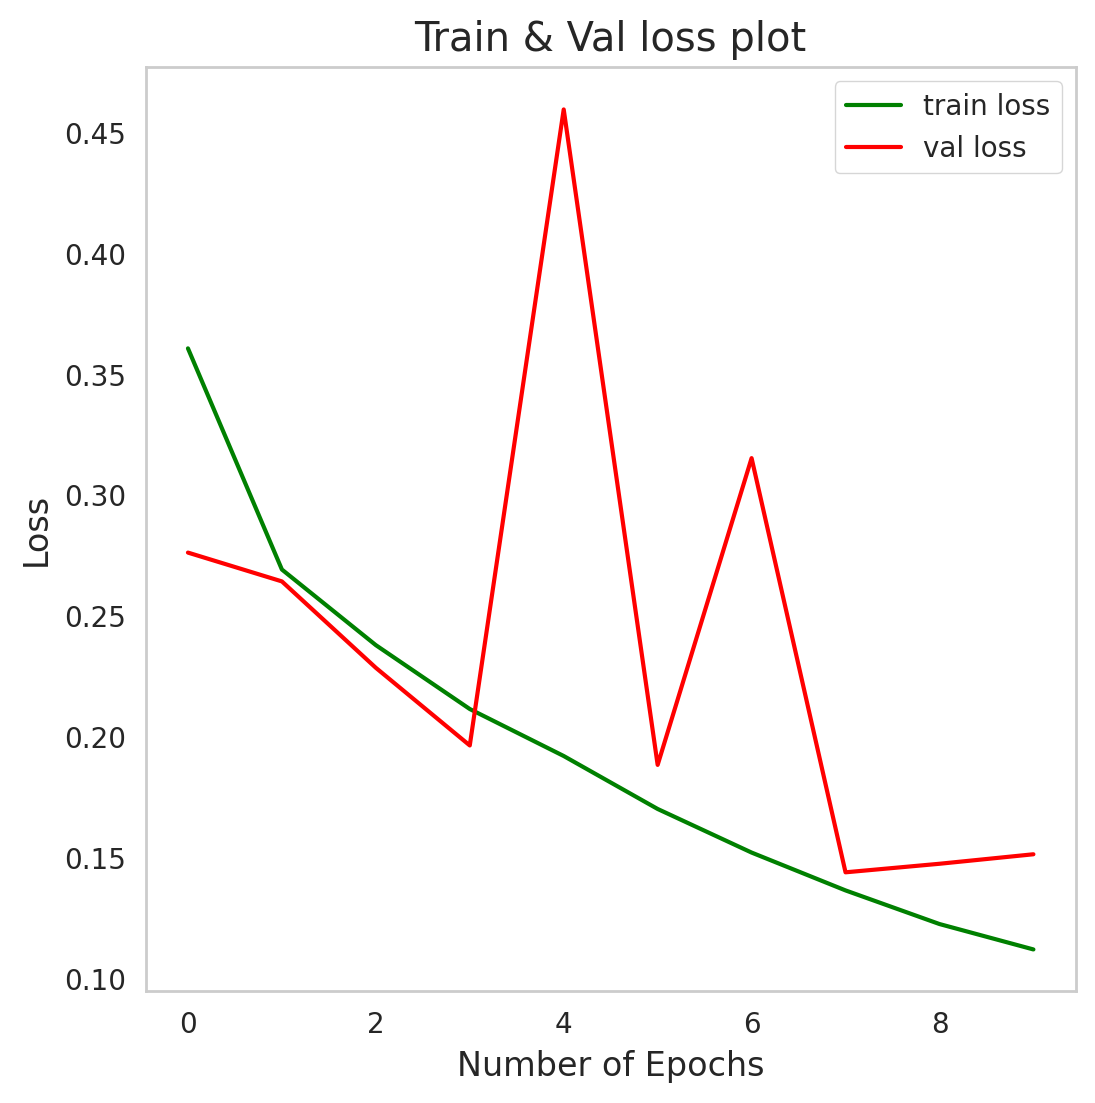

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss_values)), train_loss_values, color='green', label='train loss')
plt.plot(range(len(val_loss_values)), val_loss_values, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.show()

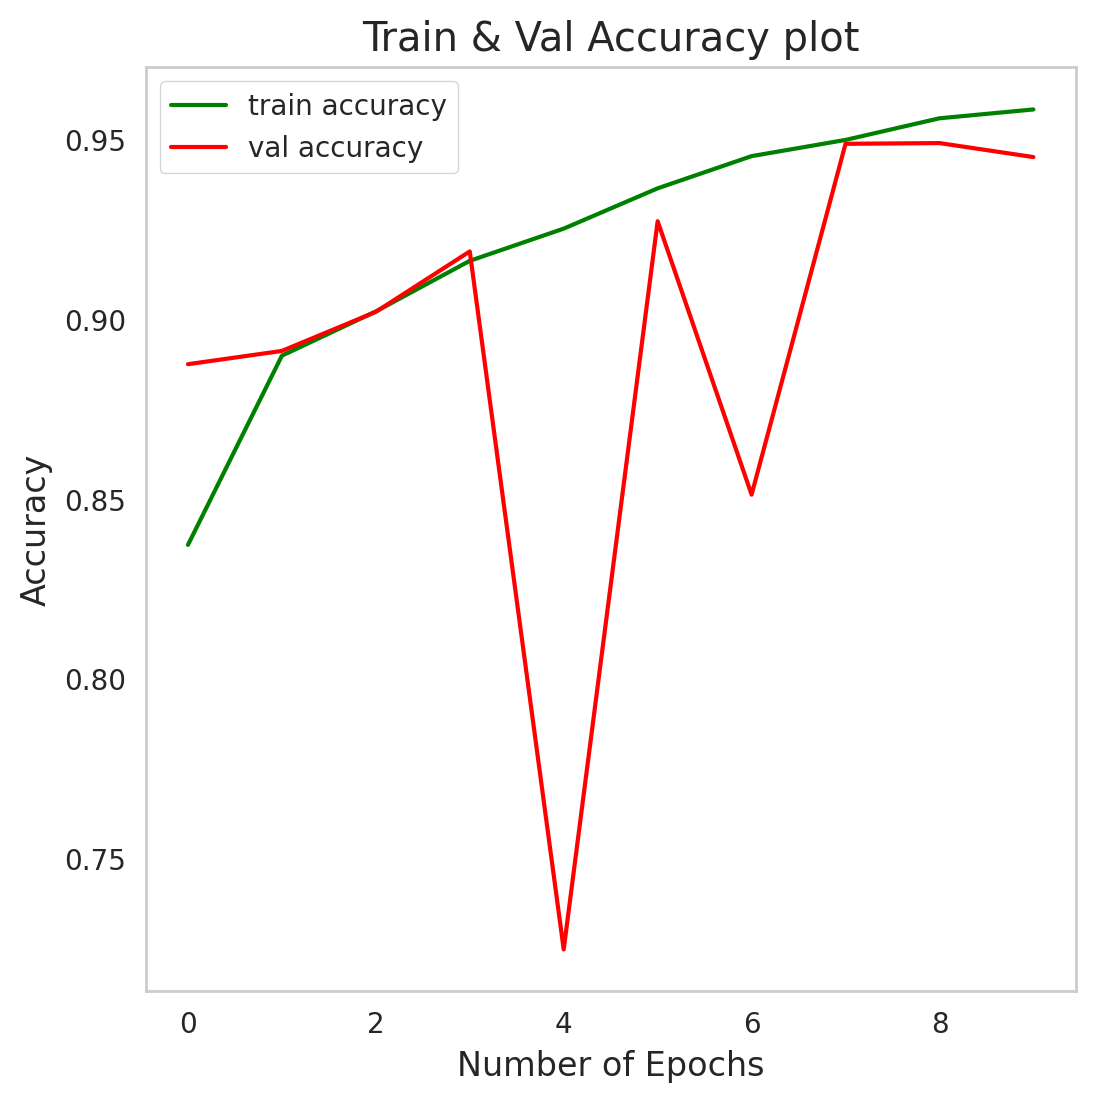

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_acc_values)), train_acc_values, color='green', label='train accuracy')
plt.plot(range(len(val_acc_values)), val_acc_values, color='red', label='val accuracy')
plt.legend()
plt.title("Train & Val Accuracy plot")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.show()

## Geoencoding information

In [ ]:
# train = pd.DataFrame(zip(X_train, y_train), columns = ['path', 'label'])
# test = pd.DataFrame(zip(X_test, y_test), columns = ['path', 'label'])
# val = pd.DataFrame(zip(X_val, y_val), columns = ['path', 'label'])

print(train.head())
print(test.head())
print(val.head())

                                                path      label
0  ../content/new-hurricane-damage-sat-images-unz...    Damaged
1  ../content/new-hurricane-damage-sat-images-unz...  Undamaged
2  ../content/new-hurricane-damage-sat-images-unz...  Undamaged
3  ../content/new-hurricane-damage-sat-images-unz...    Damaged
4  ../content/new-hurricane-damage-sat-images-unz...  Undamaged
                                                path      label
0  ../content/new-hurricane-damage-sat-images-unz...    Damaged
1  ../content/new-hurricane-damage-sat-images-unz...    Damaged
2  ../content/new-hurricane-damage-sat-images-unz...    Damaged
3  ../content/new-hurricane-damage-sat-images-unz...  Undamaged
4  ../content/new-hurricane-damage-sat-images-unz...    Damaged
                                                path      label
0  ../content/new-hurricane-damage-sat-images-unz...    Damaged
1  ../content/new-hurricane-damage-sat-images-unz...    Damaged
2  ../content/new-hurricane-damage-sat-i

In [ ]:
merged_df.head()

,path,distance,complete_post_catalog_id,label,coord_x,coord_y,elevation
0,../content/new-hurricane-damage-sat-images-unz...,21171.075020,105001000B95E200,Undamaged,-95.370587,29.768079,13.291325
1,../content/new-hurricane-damage-sat-images-unz...,170243.223900,1.04E+12,Damaged,-96.939641,28.764159,24.749996
2,../content/new-hurricane-damage-sat-images-unz...,8949.754394,105001000B95E100,Damaged,-95.513427,29.744835,18.762648
3,../content/new-hurricane-damage-sat-images-unz...,50602.155240,105001000B95E200,Damaged,-95.066049,29.831623,2.302779
4,../content/new-hurricane-damage-sat-images-unz...,172074.909300,1.04E+12,Damaged,-96.976177,28.775391,23.128298


In [ ]:
print(train.shape)
train_geo = train.merge(merged_df, on = ['path', 'label'])
print(train_geo.shape)
train_geo = train_geo.drop(['path', 'complete_post_catalog_id', 'coord_x', 'coord_y'], axis = 1)
print(train_geo.shape)
print(train_geo.head())

(14625, 2)
(14625, 7)
(14625, 3)
       label      distance  elevation
0    Damaged   47144.93420   3.369513
1  Undamaged   20008.74272  17.617531
2  Undamaged   17759.57376  22.044638
3    Damaged  163664.69290   4.656179
4  Undamaged   14350.69827  18.806595


In [ ]:
print(test.shape)
test_geo = test.merge(merged_df, on = ['path', 'label'])
print(test_geo.shape)
test_geo = test_geo.drop(['path', 'complete_post_catalog_id', 'coord_x', 'coord_y'], axis = 1)
print(test_geo.shape)
print(test_geo.head())

(4876, 2)
(4876, 7)
(4876, 3)
       label       distance  elevation
0    Damaged   37074.113150  12.836817
1    Damaged  189825.379000   3.471763
2    Damaged    3153.302975  22.774355
3  Undamaged   22580.262150  39.733120
4    Damaged    2528.087713  24.841795


In [ ]:
print(val.shape)
val_geo = val.merge(merged_df, on = ['path', 'label'])
print(val_geo.shape)
val_geo = val_geo.drop(['path', 'complete_post_catalog_id', 'coord_x', 'coord_y'], axis = 1)
print(val_geo.shape)
print(val_geo.head())

(4876, 2)
(4876, 7)
(4876, 3)
       label       distance  elevation
0    Damaged    5568.247691  33.374786
1    Damaged  179199.282500   1.342378
2    Damaged   43576.370680  16.895813
3    Damaged    5458.811463  33.312046
4  Undamaged   13001.612070  42.055183


In [ ]:
print(train_dataset.class_to_idx)
print(validation_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'damage': 0, 'no_damage': 1}
{'damage': 0, 'no_damage': 1}
{'damage': 0, 'no_damage': 1}


In [ ]:
X_train_geo = train_geo[['distance' , 'elevation']]
Y_train_geo = train_geo[['label']]
X_train_geo_data = np.array(X_train_geo, dtype=np.float32)
print(np.unique(Y_train_geo))
Y_train_geo_num = np.where(Y_train_geo == 'Damaged', 0, 1)
print(np.unique(Y_train_geo, return_counts = True))
print(np.unique(Y_train_geo_num, return_counts = True))  

['Damaged' 'Undamaged']
(array(['Damaged', 'Undamaged'], dtype=object), array([8432, 6193]))
(array([0, 1]), array([8432, 6193]))


In [ ]:
X_val_geo = val_geo[['distance' , 'elevation']]
Y_val_geo = val_geo[['label']]
X_val_geo_data = np.array(X_val_geo, dtype=np.float32)
Y_val_geo_num = np.where(Y_val_geo == 'Damaged', 0, 1) 

In [ ]:
X_train_geo_tensor = torch.Tensor(X_train_geo_data)
Y_train_geo_tensor = torch.Tensor(Y_train_geo_num)

X_val_geo_tensor = torch.Tensor(X_val_geo_data)
Y_val_geo_tensor = torch.Tensor(Y_val_geo_num)

## Updated model to include both

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0),
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU()
        )

        self.geo_encoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU()
        )

        self.fusion_layers = nn.Sequential(
            nn.Linear(516, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x_img, x_geo):
        x_img_out = self.cnn(x_img)
        x_geo_out = self.geo_encoder(x_geo)
        x_combined = torch.cat((x_img_out, x_geo_out), dim=1)
        out = self.fusion_layers(x_combined)
        # return out.squeeze()
        return out

In [ ]:
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, img_data, geo_data, labels):
        self.img_data = img_data
        self.geo_data = geo_data
        self.labels = labels

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        return self.img_data[idx][0], self.geo_data[idx], self.labels[idx]

# Update the data loaders
train_dataset_custom = CustomDataset(train_dataset, X_train_geo_tensor, Y_train_geo_tensor)
validation_dataset_custom = CustomDataset(validation_dataset, X_val_geo_tensor, Y_val_geo_tensor)

train_loader = DataLoader(train_dataset_custom, batch_size=20, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset_custom, batch_size=20, shuffle=False, num_workers=4)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().to(device)

# Set the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for (inputs_img, inputs_geo, labels) in train_loader:
        inputs_img, inputs_geo, labels = inputs_img.to(device), inputs_geo.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs_img, inputs_geo)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_dataset)

    model.eval()
    validation_loss = 0.0
    validation_acc = 0.0
    with torch.no_grad():
        for (inputs_img, inputs_geo, labels) in validation_loader:
            inputs_img, inputs_geo, labels = inputs_img.to(device), inputs_geo.to(device), labels.to(device)
            outputs = model(inputs_img, inputs_geo)
            loss = criterion(outputs, labels.float())

            validation_loss += loss.item()
            validation_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

    validation_loss /= len(validation_loader)
    validation_acc /= len(validation_dataset)

    train_acc_values.append(train_acc)
    val_acc_values.append(validation_acc)
    train_loss_values.append(train_loss)
    val_loss_values.append(validation_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}')
    print(f'Validation Loss: {validation_loss:.4f}  Validation Acc: {validation_acc:.4f}')

Epoch 1/10
Train Loss: 0.2486  Train Acc: 0.8938
Validation Loss: 0.2116  Validation Acc: 0.9110
Epoch 2/10
Train Loss: 0.2163  Train Acc: 0.9082
Validation Loss: 0.2043  Validation Acc: 0.9126
Epoch 3/10
Train Loss: 0.2107  Train Acc: 0.9094
Validation Loss: 0.2041  Validation Acc: 0.9120
Epoch 4/10
Train Loss: 0.2092  Train Acc: 0.9097
Validation Loss: 0.2216  Validation Acc: 0.9050
Epoch 5/10
Train Loss: 0.2071  Train Acc: 0.9106
Validation Loss: 0.2246  Validation Acc: 0.9026
Epoch 6/10
Train Loss: 0.2060  Train Acc: 0.9123
Validation Loss: 0.3076  Validation Acc: 0.8780
Epoch 7/10
Train Loss: 0.2054  Train Acc: 0.9117
Validation Loss: 0.4208  Validation Acc: 0.8712
Epoch 8/10
Train Loss: 0.2021  Train Acc: 0.9149
Validation Loss: 0.2582  Validation Acc: 0.8968
Epoch 9/10
Train Loss: 0.2017  Train Acc: 0.9149
Validation Loss: 0.1985  Validation Acc: 0.9145
Epoch 10/10
Train Loss: 0.2026  Train Acc: 0.9127
Validation Loss: 0.2056  Validation Acc: 0.9186


In [ ]:
X_test_geo = test_geo[['distance' , 'elevation']]
Y_test_geo = test_geo[['label']]
X_test_geo_data = np.array(X_test_geo, dtype=np.float32)
Y_test_geo_num = np.where(Y_test_geo == 'Damaged', 0, 1)

X_test_geo_tensor = torch.Tensor(X_test_geo_data)
Y_test_geo_tensor = torch.Tensor(Y_test_geo_num)

# Create test dataset and DataLoader
test_dataset_custom = CustomDataset(test_dataset, X_test_geo_tensor, Y_test_geo_tensor)
test_loader = DataLoader(test_dataset_custom, batch_size=20, shuffle=False, num_workers=0)

# Evaluate the model on the test dataset
model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for (inputs_img, inputs_geo, labels) in test_loader:
        inputs_img, inputs_geo, labels = inputs_img.to(device), inputs_geo.to(device), labels.to(device)
        outputs = model(inputs_img, inputs_geo)
        loss = criterion(outputs, labels.float())

        test_loss += loss.item()
        test_acc += ((outputs > 0.5).float() == labels.float()).float().sum().item()

test_loss /= len(test_loader)
test_acc /= len(test_dataset_custom)

print(f'Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}')

Test Loss: 0.2235  Test Acc: 0.9102


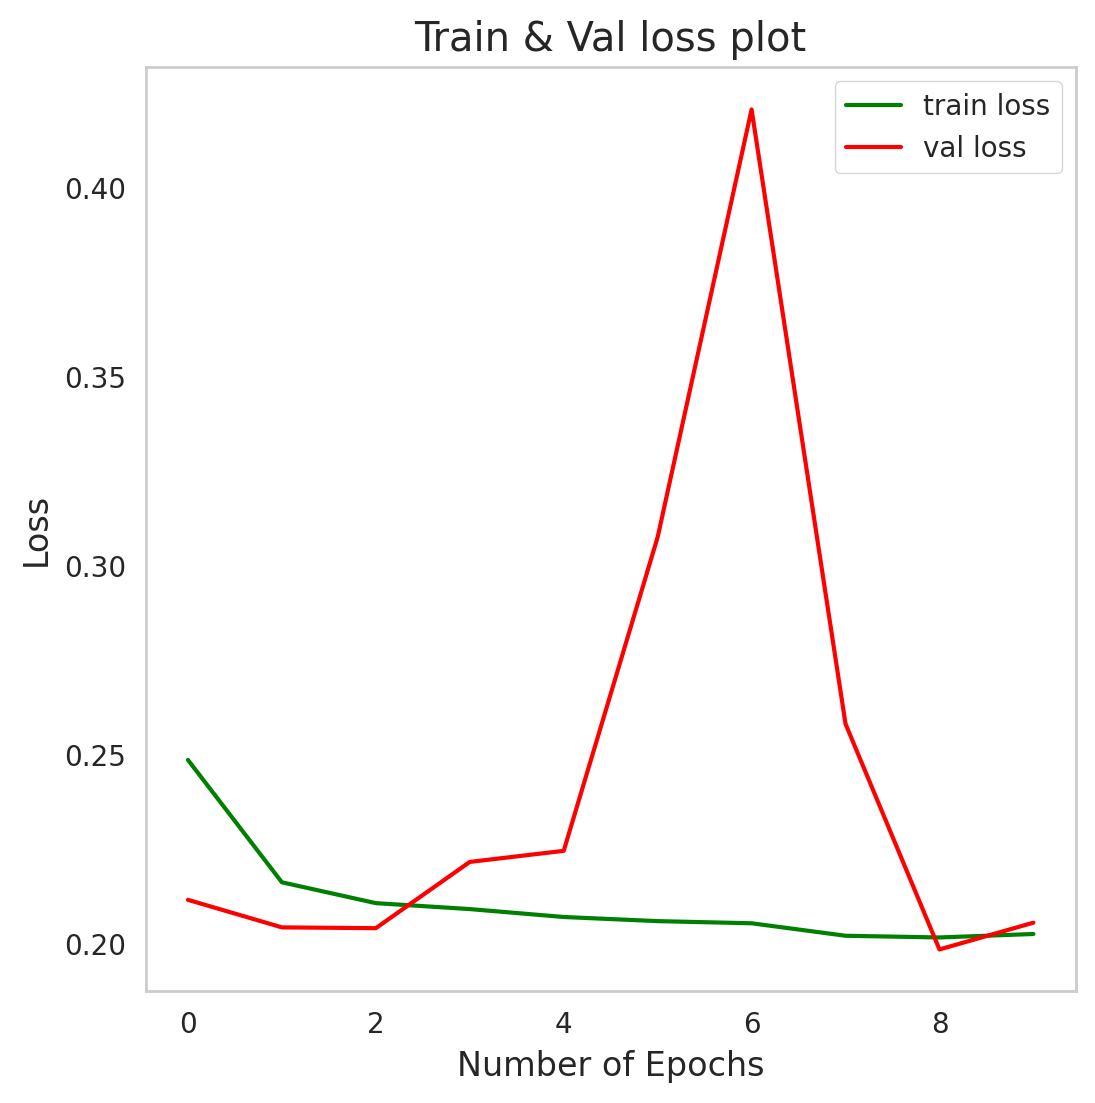

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss_values)), train_loss_values, color='green', label='train loss')
plt.plot(range(len(val_loss_values)), val_loss_values, color='red', label='val loss')
plt.legend()
plt.title("Train & Val loss plot")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.show()

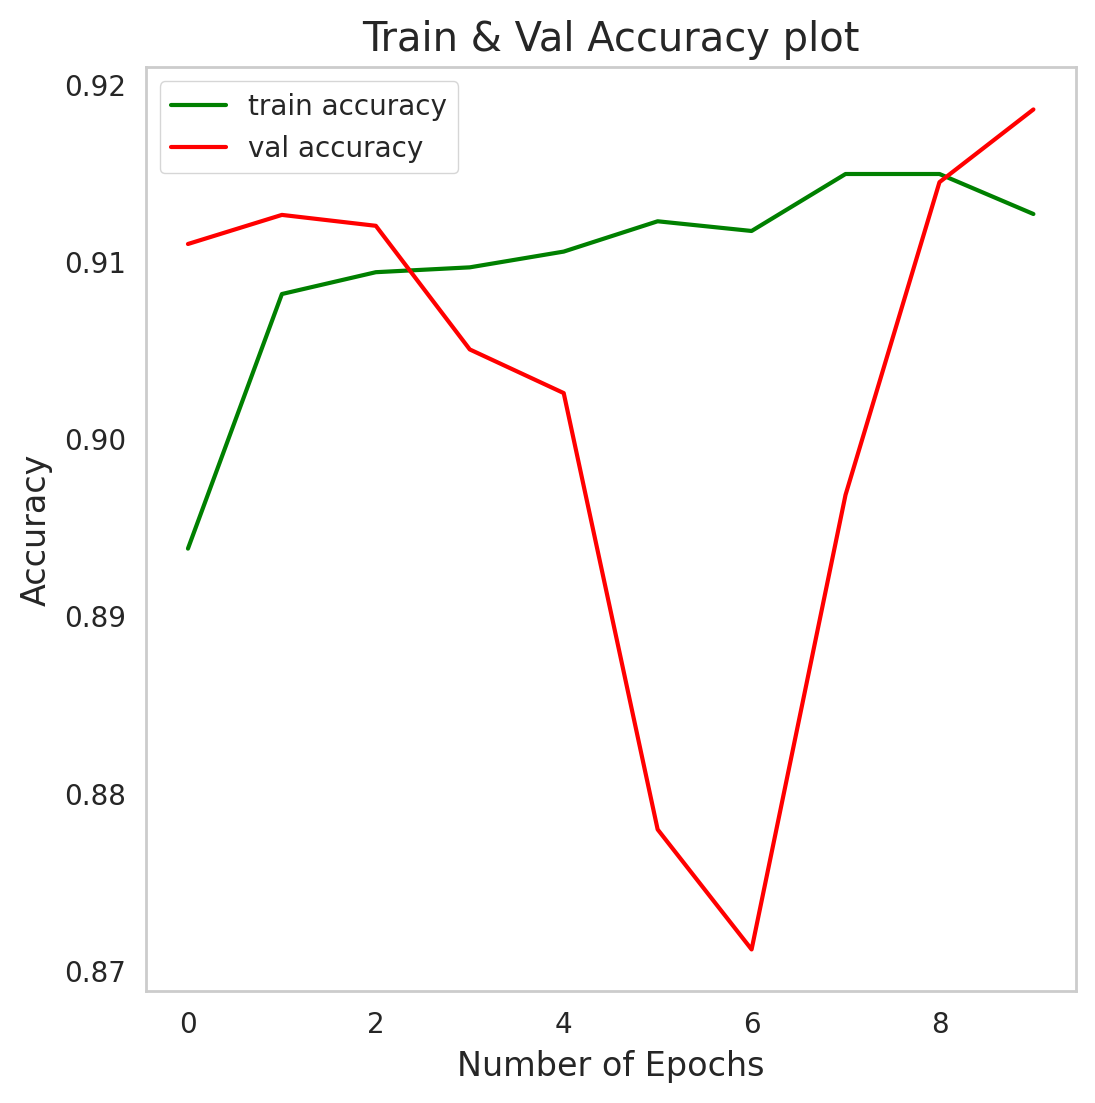

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_acc_values)), train_acc_values, color='green', label='train accuracy')
plt.plot(range(len(val_acc_values)), val_acc_values, color='red', label='val accuracy')
plt.legend()
plt.title("Train & Val Accuracy plot")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
## Load the model and pre-process the data

In [ ]:
model_path = 'model_baseline2.pth'
# Instantiate the model architecture
loaded_model = MyModel()
# Load the saved state_dict
loaded_model.load_state_dict(torch.load(model_path))
# Set the model to evaluation mode
loaded_model.eval()

In [ ]:
loaded_model